# Imports

In [1]:
import pandas as pd, numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---

# Carga de datos

In [2]:
auctions = pd.read_pickle("../../data/tp2/auctions_tp2_formateado.pkl")

In [3]:
installs = pd.read_pickle("../../data/tp2/installs_tp2_formateado.pkl")

In [4]:
events = pd.read_pickle("../../data/tp2/events_tp2_formateado.pkl")

In [5]:
clicks = pd.read_pickle("../../data/tp2/clicks_tp2_formateado.pkl")

---

# Cargo targets de la competencia

In [6]:
targets = pd.read_pickle("../../data/tp2/ref_hashes_target.pkl")

---

# Renombro columnas

In [7]:
events.rename(columns={"ref_hash" : "device_id"}, inplace=True)

In [8]:
installs.rename(columns={"ref_hash" : "device_id"}, inplace=True)

In [9]:
clicks.rename(columns={"ref_hash" : "device_id"}, inplace=True)

---

# Armo ventanas

In [10]:
for ventana_nro in range(1,6):
    auctions["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= auctions["date"].dt.day) & ((auctions["date"].dt.day) <= (19+ventana_nro)))

In [11]:
auctions["ventana_final"] = (((25) <= auctions["date"].dt.day) & ((auctions["date"].dt.day) <= (27)))

In [12]:
for ventana_nro in range(1,6):
    events["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= events["date"].dt.day) & ((events["date"].dt.day) <= (19+ventana_nro)))

In [13]:
events["ventana_final"] = (((25) <= events["date"].dt.day) & ((events["date"].dt.day) <= (27)))

In [14]:
for ventana_nro in range(1,6):
    clicks["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= clicks["created"].dt.day) & ((clicks["created"].dt.day) <= (19+ventana_nro)))

In [15]:
clicks["ventana_final"] = (((25) <= clicks["created"].dt.day) & ((clicks["created"].dt.day) <= (27)))

In [16]:
for ventana_nro in range(1,6):
    installs["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= installs["created"].dt.day) & ((installs["created"].dt.day) <= (19+ventana_nro)))

In [17]:
installs["ventana_final"] = (((25) <= installs["created"].dt.day) & ((installs["created"].dt.day) <= (27)))

---

# Armo set de datos con las presencias por ventana y dataset

In [18]:
for ventana_nro in range(1, 6):
    targets["en_v{}_auctions".format(ventana_nro)] = targets.index.isin(auctions.loc[auctions["ventana_{}".format(ventana_nro)]]["device_id"])
    targets["en_v{}_events".format(ventana_nro)] = targets.index.isin(events.loc[events["ventana_{}".format(ventana_nro)]]["device_id"])
    targets["en_v{}_clicks".format(ventana_nro)] = targets.index.isin(clicks.loc[clicks["ventana_{}".format(ventana_nro)]]["device_id"])
    targets["en_v{}_installs".format(ventana_nro)] = targets.index.isin(installs.loc[installs["ventana_{}".format(ventana_nro)]]["device_id"])

In [19]:
targets["en_v{}_auctions".format("final")] = targets.index.isin(auctions.loc[auctions["ventana_{}".format("final")]]["device_id"])
targets["en_v{}_events".format("final")] = targets.index.isin(events.loc[events["ventana_{}".format("final")]]["device_id"])
targets["en_v{}_clicks".format("final")] = targets.index.isin(clicks.loc[clicks["ventana_{}".format("final")]]["device_id"])
targets["en_v{}_installs".format("final")] = targets.index.isin(installs.loc[installs["ventana_{}".format("final")]]["device_id"])

In [20]:
targets["columna_para_conteo"] = 1

---

In [21]:
apariciones = targets.groupby(['en_v1_auctions', 'en_v2_auctions', 'en_v3_auctions',
       'en_v4_auctions', 'en_v5_auctions', 'en_v1_events', 'en_v1_clicks',
       'en_v1_installs', 'en_v2_events', 'en_v2_clicks', 'en_v2_installs',
       'en_v3_events', 'en_v3_clicks', 'en_v3_installs', 'en_v4_events',
       'en_v4_clicks', 'en_v4_installs', 'en_v5_events', 'en_v5_clicks',
       'en_v5_installs', 'en_vfinal_auctions', 'en_vfinal_events',
       'en_vfinal_clicks', 'en_vfinal_installs']).agg("count").sort_values(by="columna_para_conteo", ascending=False)

In [22]:
apariciones

columna_para_conteo
en_v1_auctions en_v2_auctions en_v3_auctions en_v4_auctions en_v5_auctions en_v1_events en_v1_clicks en_v1_installs en_v2_events en_v2_clicks en_v2_installs en_v3_events en_v3_clicks en_v3_installs en_v4_events en_v4_clicks en_v4_installs en_v5_events en_v5_clicks en_v5_installs en_vfinal_auctions en_vfinal_events en_vfinal_clicks en_vfinal_installs                     
True           True           True           True           True           False        False        False          False        False        False          False        False        False          False        False        False          False        False        False          True               True             False            True                                196
False          False          False          False          False          False        False        False          False        False        False          False        False        False          False        False        False          False        False        False          True               True             False            True                                132
True           True           True           True           True           False        False        False          False        False        False          False        False        False          False        False        False          False        False        False          True               False            False            True                                 67
                                                                                                                                                             True         False        True           True         False        True           True         False        True           True               False            False            False                                64
False          False          False          False          False          False        False        False          False        False        False          False        False        False          False        False        False          False        False        False          True               False            False            True                                 56
True           True           True           True           True           False        False        False          True         False        True           True         False        True           True         False        True           False        False        False          True               False            False            False                                55
                                                                           True         False        True           True         False        True           True         False        True           False        False        False          False        False        False          True               False            False            False                                49
                                                                                                                                                             False        False        False          False        False        False          False        False        False          True               False            False            False                                49
                                                                           False        False        False          False        False        False          False        False        False          False        False        False          True         False        True           True               False            False            False                                46
                                                                                                                                                                                                      True         False        True           True       

In [52]:
apariciones_sin_installs = targets.groupby(['en_v1_auctions', 'en_v2_auctions', 'en_v3_auctions',
       'en_v4_auctions', 'en_v5_auctions', 'en_v1_events', 'en_v1_clicks',
        'en_v2_events', 'en_v2_clicks', 
       'en_v3_events', 'en_v3_clicks',  'en_v4_events',
       'en_v4_clicks', 'en_v5_events', 'en_v5_clicks',
      'en_vfinal_auctions', 'en_vfinal_events',
       'en_vfinal_clicks']).agg("count").sort_values(by="columna_para_conteo", ascending=False)

# Analisis ventana a ventana

## Para la ventana 1

In [59]:
targets.groupby(['en_v1_auctions', 'en_v1_events', 'en_v1_clicks',
       'en_v1_installs']).agg({"columna_para_conteo" : "count"})

columna_para_conteo
en_v1_auctions en_v1_events en_v1_clicks en_v1_installs                     
False          False        False        False                           974
                                         True                             47
               True         False        False                            77
                                         True                            194
True           False        False        False                          1359
                                         True                            238
                            True         False                            36
                                         True                              3
               True         False        False                           249
                                         True                            807
                            True         False                            18
                                         True                             35

## Busco en los datasets dispositivos que tengan las mismas características

In [61]:
dispositivos_en_v1_auctions = auctions.loc[auctions["ventana_1"]]["device_id"].drop_duplicates().to_frame()

In [63]:
dispositivos_en_v1_auctions.set_index("device_id", inplace=True)

In [75]:
dispositivos_en_v1_auctions["en_v{}_auctions".format("1")] = 1
dispositivos_en_v1_auctions["en_v{}_events".format("1")] = dispositivos_en_v1_auctions.index.isin(events.loc[events["ventana_{}".format("1")]]["device_id"])
dispositivos_en_v1_auctions["en_v{}_clicks".format("1")] = dispositivos_en_v1_auctions.index.isin(clicks.loc[clicks["ventana_{}".format("1")]]["device_id"])
dispositivos_en_v1_auctions["en_v{}_installs".format("1")] = dispositivos_en_v1_auctions.index.isin(installs.loc[installs["ventana_{}".format("1")]]["device_id"])

In [76]:
dispositivos_en_v1_auctions["columna_para_conteo"] = 1

In [78]:
dispositivos_en_v1_auctions.groupby(['en_v1_auctions', 'en_v1_events', 'en_v1_clicks',
       'en_v1_installs']).agg({"columna_para_conteo" : "count"})

columna_para_conteo
en_v1_auctions en_v1_events en_v1_clicks en_v1_installs                     
1              False        False        False                        213399
                                         True                          21948
                            True         False                          5332
                                         True                            388
               True         False        False                         32896
                                         True                          41000
                            True         False                          2035
                                         True                           1327

# Me quedo solamente con los que estan en los cuatro sets de datos

In [91]:
felices_los_4 = dispositivos_en_v1_auctions.loc[(dispositivos_en_v1_auctions["en_v1_events"]) & (dispositivos_en_v1_auctions["en_v1_clicks"]) & (dispositivos_en_v1_auctions["en_v1_installs"])]

In [95]:
felices_los_4 = felices_los_4.index.to_frame().drop("device_id", axis=1)

In [97]:
felices_los_4.head()

""
device_id
2019857230204211797
4220751993672827036
3814346826519918652
5126376739247993858
228293614810825188


In [102]:
features_de_la_v1 = pd.read_pickle("../modelo/features/auctions_train_ventana_1.pkl")
features_de_la_v1 =features_de_la_v1.merge(pd.read_pickle("../modelo/features/clicks_train_ventana_1.pkl"), left_index=True, right_index=True)
features_de_la_v1 =features_de_la_v1.merge(pd.read_pickle("../modelo/features/events_train_ventana_1.pkl"), left_index=True, right_index=True)

In [103]:
features_de_la_v1 = felices_los_4.merge(features_de_la_v1, left_index=True, right_index=True)

In [105]:
targets_de_la_v1 = pd.read_pickle("../modelo/targets/targets_ventana_1_auctions.pkl")

In [106]:
features_de_la_v1 = features_de_la_v1.merge(targets_de_la_v1, left_index=True, right_index=True)

In [117]:
# 
X, y = features_de_la_v1.iloc[:,:-1], features_de_la_v1.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor()

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 83167.971908


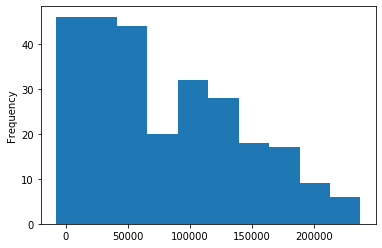

In [118]:
pd.Series(preds).plot(kind="hist")

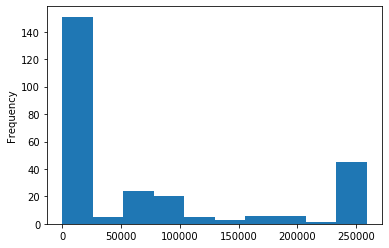

In [113]:
y_test.plot(kind="hist")